In [1]:
import pandas as pd

#Cargamos las versiones codificadas de los dataframes de entrenamiento y testeo
df_train_final = pd.read_csv('train_clean(codificado).csv', encoding='UTF-8',sep=',')
df_test_final = pd.read_csv('test_clean(codificado).csv', encoding='UTF-8', sep=',')

# Verificación de forma y columnas
print("Archivos importados correctamente.")
print(f"→ df_train_final: {df_train_final.shape}")
print(f"→ df_test_final: {df_test_final.shape}")

# Verificar que Credit_Score está en train y no en test
assert 'Credit_Score_Encoded' in df_train_final.columns, "Credit_Score no está en df_train_final"
assert 'Credit_Score_Encoded' not in df_test_final.columns, "Credit_Score NO debería estar en df_test_final"

Archivos importados correctamente.
→ df_train_final: (92400, 36)
→ df_test_final: (46177, 35)


In [17]:
# Preparación del dataframe de entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Separación variables predictoras y target
X = df_train_final.drop(columns=['Credit_Score_Encoded','Customer_ID','ID','Name','SSN','Month'])
y = df_train_final['Credit_Score_Encoded']

# Separar set de validación interna para evaluar modelos
X_train, X_Val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Definimos una función para evaluar cada modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluar_modelo(modelo, X_train, X_val, y_train, y_val, nombre_modelo="Modelo"):
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicción
    y_pred = modelo.predict(X_val)
    
    # Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\nEvaluación de: {nombre_modelo}")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_val, y_pred, target_names=['Poor', 'Standard', 'Good']))
    
    # Matriz de confusión estandarizada por fila (clase real)
    cm = confusion_matrix(y_val, y_pred)
    cm_normalizada = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalizada, display_labels=modelo.classes_)
    disp.plot(cmap='Blues', values_format=".2f", ax=ax)
    plt.title(f'Matriz de Confusión Normalizada - {nombre_modelo}')
    plt.grid(False)
    plt.show()

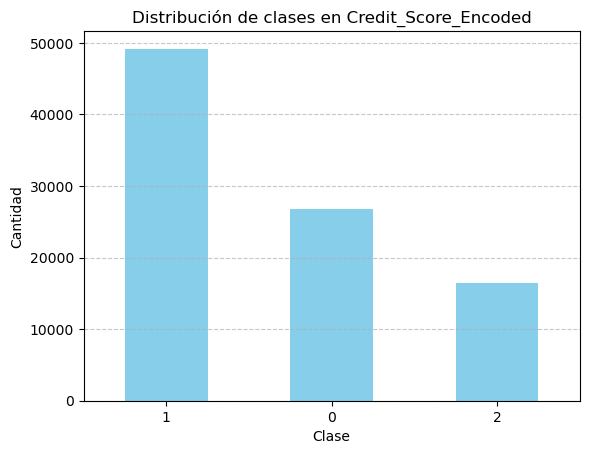

Distribución porcentual:
Credit_Score_Encoded
1    53.23
0    28.98
2    17.80
Name: proportion, dtype: float64

Dado que existe desbalance de clases, es necesario aplicar SMOTE (Synthetic Minority Over-Sampling Technique), solo al set de entrenamiento


In [19]:
# Diagnóstico de desbalance de clases 
import seaborn as sns
import matplotlib.pyplot as plt

#Revisión de distribución de clases
y.value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de clases en Credit_Score_Encoded')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#También lo mostramos como porcentajes
print('Distribución porcentual:')
print(round(y.value_counts(normalize=True)*100,2))

print('\nDado que existe desbalance de clases, es necesario aplicar SMOTE (Synthetic Minority Over-Sampling Technique), solo al set de entrenamiento')

In [20]:
#Aplicación de SMOTE para desbalance de clases
from imblearn.over_sampling import SMOTE

# Aplica SMOTE solo a X_train e y_train (nunca al test ni validación)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Confirmamos nueva distribución
print("\n[INFO] Nuevas proporciones tras SMOTE:")
print(y_train_resampled.value_counts())


[INFO] Nuevas proporciones tras SMOTE:
Credit_Score_Encoded
0    39346
1    39346
2    39346
Name: count, dtype: int64



Evaluación de: Regresión Logística Mutliclase (Softmax)
Accuracy: 0.5754

Reporte de Clasificación:
              precision    recall  f1-score   support

        Poor       0.58      0.65      0.61      5355
    Standard       0.75      0.46      0.57      9836
        Good       0.41      0.80      0.54      3289

    accuracy                           0.58     18480
   macro avg       0.58      0.64      0.57     18480
weighted avg       0.64      0.58      0.58     18480



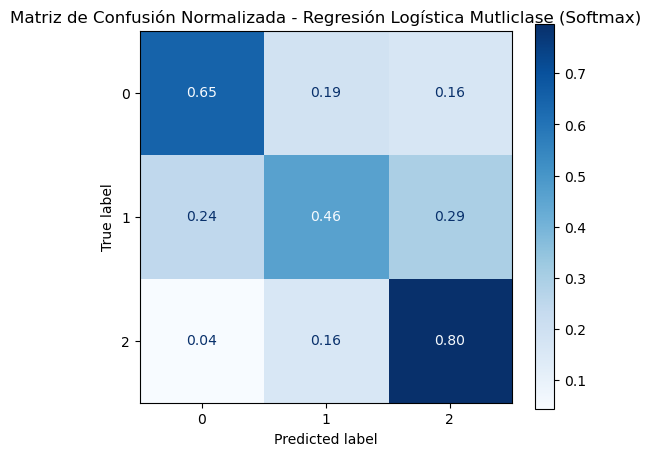


Luego de implementar Regresión Logística Multiclase mediante Softmax sensibilizando sus parámetros, sacamos las siguientes conclusiones: En general el modelo rinde de manera insuficiente, llegando a un Accuracy del 58% (clasifica correctamente un 58% de los datos en sus clases reales). Viendo nuestra Matriz de Confusión, el modelo fue capaz de predecir correctamente el 65% de la clase "Poor", un 46% la clase "Standard" y un 80% la clase "Good".

Estos resultados se dan ya que la Regresión Logística Multiclase es un modelo basado en la linealidad, el cual no es capaz de capturar relaciones complejas (que es el caso de un credit scoring). Ajustar penalty para descartar descriptores irrelevantes castiga al modelo por coeficentes grandes, pero no cambia la arquitectura del mismo, por lo tanto no hay más complejidad que ganar.


In [21]:
#Regresión Logística Multiclase usando Función Softmax
from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression(
    multi_class = 'multinomial',
    solver='newton-cg',
    penalty='l2',
    max_iter = 5000,
    random_state = 42,
    C=1.0
)

evaluar_modelo(modelo_lr, X_train_resampled, X_Val, y_train_resampled, y_val, nombre_modelo='Regresión Logística Mutliclase (Softmax)')

print('\nLuego de implementar Regresión Logística Multiclase mediante Softmax sensibilizando sus parámetros, sacamos las siguientes conclusiones: ' \
'En general el modelo rinde de manera insuficiente, llegando a un Accuracy del 58% (clasifica correctamente un 58% de los datos en sus clases ' \
'reales). Viendo nuestra Matriz de Confusión, el modelo fue capaz de predecir correctamente el 65% de la clase "Poor", un 46% la clase "Standard" y un 80%' \
' la clase "Good".')

print('\nEstos resultados se dan ya que la Regresión Logística Multiclase es un modelo basado en la linealidad, el cual no es capaz de capturar relaciones ' \
'complejas (que es el caso de un credit scoring). Ajustar penalty para descartar descriptores irrelevantes castiga al modelo por coeficentes grandes, ' \
'pero no cambia la arquitectura del mismo, por lo tanto no hay más complejidad que ganar.')


Evaluación de: Naive Bayes
Accuracy: 0.4056

Reporte de Clasificación:
              precision    recall  f1-score   support

        Poor       0.44      0.79      0.57      5355
    Standard       0.71      0.05      0.10      9836
        Good       0.34      0.85      0.48      3289

    accuracy                           0.41     18480
   macro avg       0.50      0.56      0.38     18480
weighted avg       0.57      0.41      0.30     18480



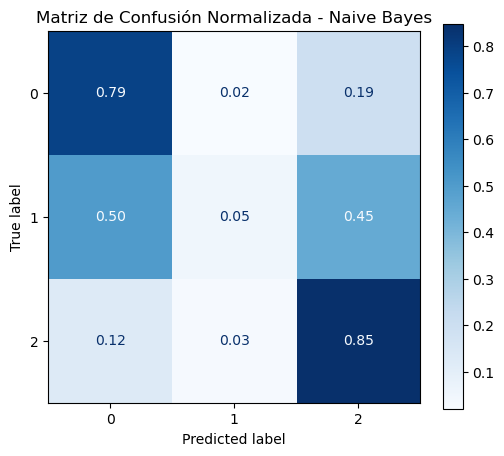


Luego de implementar Naive Bayes, sacamos las siguientes conclusiones: En general el modelo rinde dejando mucho que desea, llegando a un Accuracy del 40.56% (clasifica correctamente un 41% de los datos en sus clases reales). Si bien el modelo fue capaz de predecir correctamente sobre el 80% en 2 clases, en el caso de la clase "Good" solamente fue capaz de predecir un 5% bien.

Estos resultados son esperables en nuestro caso de credit_scoring, ya que Naive Bayes posee el supuesto de independencia condicional, es decir, que las variables predictoras son independientes entre sí dado la clase, lo que en la realidad (y en nuestro dataset) esto casi nunca se cumple (por ejemplo existe correlación entre Monthly_Balance y Amount_invested_monthly (ingreso mensual y ahorro mensual)). Este supuesto hace que Naive Bayes sobreeestime o subestime las verdades probabilidades de las clases.

Por otro lado, en su version Gaussiana(GaussianNB), Naive Bayes asume que los datos numéricos siguen una distr

In [22]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB

#Instanciamos el modelo base
nb_base = GaussianNB()

#Entrenamos y evaluamos
evaluar_modelo(nb_base, X_train_resampled, X_Val, y_train_resampled, y_val, nombre_modelo='Naive Bayes')

print('\nLuego de implementar Naive Bayes, sacamos las siguientes conclusiones: ' \
'En general el modelo rinde dejando mucho que desea, llegando a un Accuracy del 40.56% (clasifica correctamente un 41% de los datos en sus clases ' \
'reales). Si bien el modelo fue capaz de predecir correctamente sobre el 80% en 2 clases, en el caso de la clase "Good" solamente fue capaz de '
'predecir un 5% bien.')

print('\nEstos resultados son esperables en nuestro caso de credit_scoring, ya que Naive Bayes posee el supuesto de independencia condicional, es decir, ' \
'que las variables predictoras son independientes entre sí dado la clase, lo que en la realidad (y en nuestro dataset) esto casi nunca se cumple (por ejemplo' \
' existe correlación entre Monthly_Balance y Amount_invested_monthly (ingreso mensual y ahorro mensual)). Este supuesto hace que Naive Bayes sobreeestime ' \
'o subestime las verdades probabilidades de las clases.')

print('\nPor otro lado, en su version Gaussiana(GaussianNB), Naive Bayes asume que los datos numéricos siguen una distribución normal, lo que rara vez ' \
'es cierto tras una estandarización o presencia de asimetrías, lo que afecta los puntajes de probabilidad calculados.')

[INFO] Mejor configuración de hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Evaluación de: Árbol de Decisión
Accuracy: 0.7383

Reporte de Clasificación:
              precision    recall  f1-score   support

        Poor       0.74      0.75      0.74      5355
    Standard       0.77      0.74      0.76      9836
        Good       0.66      0.69      0.68      3289

    accuracy                           0.74     18480
   macro avg       0.72      0.73      0.73     18480
weighted avg       0.74      0.74      0.74     18480



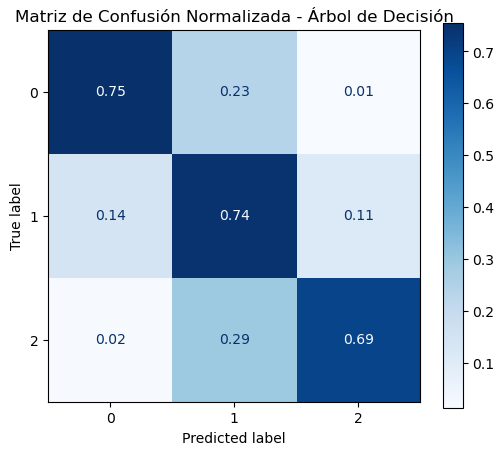


Luego de implementar el Árbol de Decisión a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos una mejoría notable respecto a los modelos anteriores, logrando un Accuracy del 73.83%, es decir, el modelo es capaz de clasificar correctamente al 74% de los datos deentrenamiento. Asimismo, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases (como los anteriores).

Estos resultados se dan ya que el modelo a diferencia de los anteriores captura relaciones no lineales, patrones complejos comúnes en este tipo de datasets. Los árboles de decisión además no se sesgan si hay desbalance de clases (independiente de la aplicación de SMOTE). Además, la optimización de sus hiperparámetros mediante GridSearchCV permite que el árbol tenga mejor capacidad de generalización sin caer en el overfitting.


In [23]:
# Árbol de decisión para clasificación

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Crear modelo base
dt_model = DecisionTreeClassifier(random_state=42)

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'criterion': ['entropy'],  # Usamos entropía en lugar de gini
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Búsqueda con validación cruzada (optimización de parámetros del modelo)
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar búsqueda sobre los datos balanceados
grid_search.fit(X_train_resampled, y_train_resampled)

# Mejor modelo obtenido
best_dt_model = grid_search.best_estimator_

# Evaluación final con validación interna
print('[INFO] Mejor configuración de hiperparámetros:', grid_search.best_params_)
evaluar_modelo(best_dt_model, X_train_resampled, X_Val, y_train_resampled, y_val, nombre_modelo='Árbol de Decisión')

print('\nLuego de implementar el Árbol de Decisión a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos una mejoría notable ' \
'respecto a los modelos anteriores, logrando un Accuracy del 73.83%, es decir, el modelo es capaz de clasificar correctamente al 74% de los datos de' \
'entrenamiento. Asimismo, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases (como los anteriores).')

print('\nEstos resultados se dan ya que el modelo a diferencia de los anteriores captura relaciones no lineales, patrones complejos comúnes en este tipo de ' \
'datasets. Los árboles de decisión además no se sesgan si hay desbalance de clases (independiente de la aplicación de SMOTE). Además, la optimización ' \
'de sus hiperparámetros mediante GridSearchCV permite que el árbol tenga mejor capacidad de generalización sin caer en el overfitting.')

[INFO] Mejor configuración de hiperparámetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}

Evaluación de: RandomForest
Accuracy: 0.8057

Reporte de Clasificación:
              precision    recall  f1-score   support

        Poor       0.78      0.86      0.82      5355
    Standard       0.85      0.78      0.81      9836
        Good       0.75      0.80      0.77      3289

    accuracy                           0.81     18480
   macro avg       0.79      0.81      0.80     18480
weighted avg       0.81      0.81      0.81     18480



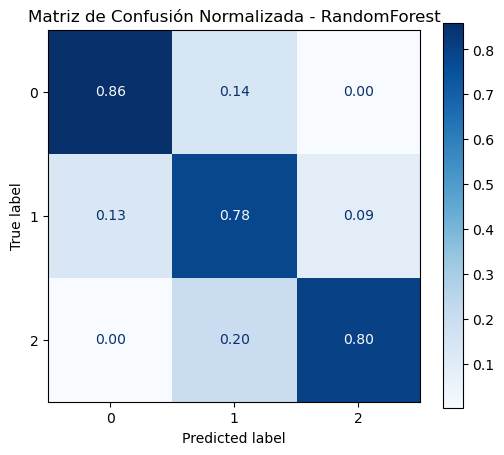


Luego de implementar RandomForest a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos una mejoría notable respecto al Árbol de Decisión, logrando un Accuracy del 80.57%, es decir, el modelo es capaz de clasificar correctamente al 81% de los datos deentrenamiento. Al igual que el Árbol de Decisión, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases.

Los resultados mejoran aún más respecto al Árbol de Decisión ya que éstos tienden a sobreajustar los datos, mientras que RandomForest promedia múltiples árboles entrenados en distintos subconjuntos, reduciendo esa varianza. A su vez, RandomForest se ve menos afectado por los outliers al combinar muchos árboles de decisión. Asimismo, es capaz de detectar relaciones no lineales complejas.

 Cabe recalcar que se usó RandomizedSearchCV en vez de GridSearchCV, considerando el costo computacional de este último y la magnitud de nuestro dataset. Sin embargo, no existe

In [ ]:
# Random Forest para clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report

# Definir el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [100,200,300],      # Número de árboles
    'max_depth': [10, 20, 30, None],    # Profundidad máxima
    'min_samples_split': [2,5,10],      # Muestras mínimas para dividir nodo
    'min_samples_leaf': [1,2,6],        # Muestras mínimas en una hoja
    'max_features': ['sqrt','log2']     # Nº de características a usar en cada split
}

# Búsqueda en malla con validación cruzada
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10,
                              cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Entrenamiento con datos resampleados
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Mejor modelo encontrado
best_rf_model = random_search_rf.best_estimator_

# Evaluación sobre el set de validación
print('[INFO] Mejor configuración de hiperparámetros:', random_search_rf.best_params_)
evaluar_modelo(best_rf_model, X_train_resampled, X_Val, y_train_resampled, y_val, nombre_modelo='RandomForest')

print('\nLuego de implementar RandomForest a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos una mejoría notable ' \
'respecto al Árbol de Decisión, logrando un Accuracy del 80.57%, es decir, el modelo es capaz de clasificar correctamente al 81% de los datos de' \
'entrenamiento. Al igual que el Árbol de Decisión, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases.')

print('\nLos resultados mejoran aún más respecto al Árbol de Decisión ya que éstos tienden a sobreajustar los datos, mientras que RandomForest promedia '
'múltiples árboles entrenados en distintos subconjuntos, reduciendo esa varianza. A su vez, RandomForest se ve menos afectado por los outliers al combinar '
'muchos árboles de decisión. Asimismo, es capaz de detectar relaciones no lineales complejas.')

print('\n Cabe recalcar que se usó RandomizedSearchCV en vez de GridSearchCV, considerando el costo computacional de este último y la magnitud de nuestro ' \
'dataset. Sin embargo, no existen diferencias significativas entre las métricas finales de evaluación al comparar ambos tipos de búsqueda.')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\esteb\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:40:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[INFO] Mejor configuración de hiperparámetros: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1}


c:\Users\esteb\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:41:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Evaluación de: XGBoost
Accuracy: 0.8050

Reporte de Clasificación:
              precision    recall  f1-score   support

        Poor       0.79      0.84      0.81      5355
    Standard       0.83      0.80      0.81      9836
        Good       0.76      0.76      0.76      3289

    accuracy                           0.81     18480
   macro avg       0.79      0.80      0.80     18480
weighted avg       0.81      0.81      0.81     18480



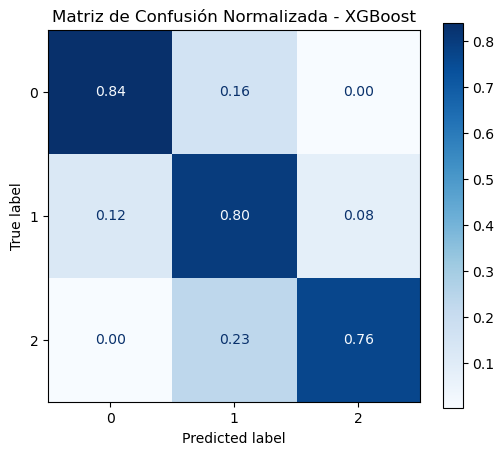


Luego de implementar XGBoost a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos resultados bastante similares a RandomForest, logrando un Accuracy del 80.5%, técnicamente el mismo que el modelo anterior. Al igual que los dos modelos anteriores, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases.

A diferencia de RandomForest, se trata de una técnica de boosting que tiene como modelo base árboles pequeños y secuenciales (mientras que RandomForest tiene Árboles grandes y aleatorios). Regulariza con penalización (alpha L1, lambda L2) lo que evita el sobreajuste. Al mismo tiempo, el uso de subsample, colsample_bytree y gamma ayudan a prevenir el sobreajuste.

Al igual que con RandomForest, se uso RandomizedSearchCV en vez de GridSearchCV, considerando el costo computacional de este último y la magnitud de nuestro dataset. Sin embargo, no existen diferencias significativas entre las métricas finales de evaluac

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Modelo base
xgb_model = XGBClassifier(
    objective='multi:softmax', #clasificación multiclase con etiquetas
    num_class = 3,             #número de clases
    use_label_encoder=False,
    eval_metric ='mlogloss',
    random_state=42,
    n_jobs=-1
)

# Definir espacio de búsqueda
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3,5,10],
    'learning_rate':[0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 1], #L1 regularization
    'reg_lambda': [1, 1.5, 2] #L2 regularization
}

# Búsqueda aleatoria de hiperparámetros
random_search_xgb = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions=param_dist,
    n_iter = 20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento 
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Mejor modelo encontrado
best_xgb_model = random_search_xgb.best_estimator_

# Evaluación
print('[INFO] Mejor configuración de hiperparámetros:', random_search_xgb.best_params_)
evaluar_modelo(best_xgb_model, X_train_resampled, X_Val, y_train_resampled, y_val, nombre_modelo='XGBoost')

print('\nLuego de implementar XGBoost a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos resultados bastante similares a ' \
'RandomForest, logrando un Accuracy del 80.5%, técnicamente el mismo que el modelo anterior. Al igual que los dos modelos anteriores, la matriz de ' \
'confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases.')

print('\nA diferencia de RandomForest, se trata de una técnica de boosting que tiene como modelo base árboles pequeños y secuenciales (mientras que ' \
'RandomForest tiene Árboles grandes y aleatorios). Regulariza con penalización (alpha L1, lambda L2) lo que evita el sobreajuste. Al mismo tiempo, el ' \
'uso de subsample, colsample_bytree y gamma ayudan a prevenir el sobreajuste.')

print('\nAl igual que con RandomForest, se uso RandomizedSearchCV en vez de GridSearchCV, considerando el costo computacional de este último y la magnitud de nuestro ' \
'dataset. Sin embargo, no existen diferencias significativas entre las métricas finales de evaluación al comparar ambos tipos de búsqueda.')

print('\nPor último, si bien se esperaba que este modelo mejorara las métricas de evaluación respecto a RandomForest, la profunda limpieza aplicada a los ' \
'dataframes favorecen modelos robustos como RandomForest más que al boosteo de este modelo. Sin embargo, sigue siendo un modelo que está al nivel de ' \
'RandomForest.')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4391
[LightGBM] [Info] Number of data points in the train set: 118038, number of used features: 30
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[INFO] Mejor configuración de hiperparámetros: {'subsample': 0.6, 'num_leaves': 63, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023173 seconds.
You can set `force_col_wise

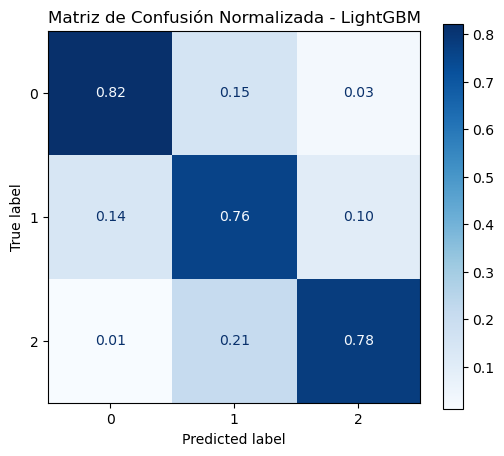


Luego de implementar LightGBM a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos resultados un poco por debajo de los dos modelos anteriores, logrando un Accuracy del 78.06%, dos puntos porcentuales menos respecto a los modelos anteriores. Al igual que los dos modelos anteriores, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases.

A diferencia de XGBoost, se trata de una técnica de boosting que se basa en crecimiento "leaf-wise", lo que permite encontrar divisiones muy profundas en regiones específicas del espacio de datos. Sin embargo, es posible que nuestro caso haya hecho divisiones muy específicas que nogeneralizan tan bien como RandomForest o XGBoost. Al mismo tiempo, LightGBM no regulariza por defecto de la misma forma que XGBoost, lo que en este caso generó un leve descenso en la capacidad predictiva. Además, haber balanceado con SMOTE hace que reste protagonismo a este modelo.

Al igual que con l

In [ ]:
# LightGBM para clasificación multiclase
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Instanciamos el modelo base
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
    n_jobs=-1
)

# Definimos el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15, -1],       # -1 significa sin límite
    'num_leaves': [15, 31, 63],         # número máximo de hojas por árbol
    'min_child_samples': [10, 20, 30],  # mínimo de datos por hoja
    'subsample': [0.6, 0.8, 1.0],       # proporción de datos para cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0] # proporción de columnas
}

# Búsqueda aleatoria de hiperparámetros
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=25,               # Número de combinaciones aleatorias a probar
    cv=5,
    verbose=1,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Entrenamiento con los datos balanceados
random_search_lgb.fit(X_train_resampled, y_train_resampled)

# Mejor modelo encontrado
best_lgb_model = random_search_lgb.best_estimator_

# Evaluación sobre el set de validación
print("[INFO] Mejor configuración de hiperparámetros:", random_search_lgb.best_params_)

# Evaluación con función personalizada
evaluar_modelo(best_lgb_model, X_train_resampled, X_Val, y_train_resampled, y_val, nombre_modelo='LightGBM')

print('\nLuego de implementar LightGBM a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos resultados un poco por debajo de ' \
'los dos modelos anteriores, logrando un Accuracy del 78.06%, dos puntos porcentuales menos respecto a los modelos anteriores. Al igual que los dos modelos ' \
'anteriores, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases.')

print('\nA diferencia de XGBoost, se trata de una técnica de boosting que se basa en crecimiento "leaf-wise", lo que permite encontrar divisiones '
'muy profundas en regiones específicas del espacio de datos. Sin embargo, es posible que nuestro caso haya hecho divisiones muy específicas que no'
'generalizan tan bien como RandomForest o XGBoost. Al mismo tiempo, LightGBM no regulariza por defecto de la misma forma que XGBoost, lo que en este ' \
'caso generó un leve descenso en la capacidad predictiva. Además, haber balanceado con SMOTE hace que reste protagonismo a este modelo.')

print('\nAl igual que con los modelos anteriores se uso RandomizedSearchCV en vez de GridSearchCV, considerando el costo computacional de este último y ' \
'la magnitud de nuestro dataset. Sin embargo, no existen diferencias significativas entre las métricas finales de evaluación al comparar ambos tipos ' \
'de búsqueda.')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[INFO] Mejor configuración de hiperparámetros: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}

Evaluación de: KNN
Accuracy: 0.7212

Reporte de Clasificación:
              precision    recall  f1-score   support

        Poor       0.70      0.76      0.73      5355
    Standard       0.79      0.69      0.74      9836
        Good       0.60      0.75      0.67      3289

    accuracy                           0.72     18480
   macro avg       0.70      0.73      0.71     18480
weighted avg       0.73      0.72      0.72     18480



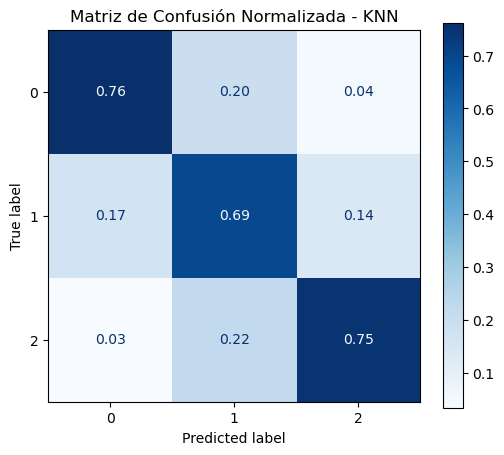


Luego de implementar KNN a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos resultados un poco por debajo de los modelos anteriores, logrando un Accuracy del 72.12%. Al igual que los dos modelos anteriores, la matriz de confusión nos muestra que el modelo no está sesgado hacia una sola clase o un par de clases.

A diferencia de todas las técnicas anteriores, KNN no aprende una función, más bien memoriza el set de entrenamiento y aplica una regla de votación a partir de las votaciones más cercanas, es decir, es un método que se basa en las distancias. Por lo tanto, es un modelo que funciona cuando las clases están bien delimitadas y separadas en el espacio vectorial. En nuestro caso y dados los resultados, existen zonas grises o bordes difusos lo que hace que el voto de vecinos cercanos no siempre represente bien la clase real. Al mismo tiempo, al tener tantas variables predictoras, KNN sufre de algo llamado "curse of dimensionality", lo que significa que a m

In [27]:
# Implementación de KNN para clasificación multiclase

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Modelo base de KNN
knn_model = KNeighborsClassifier()

# Hiperparámetros a explorar
param_dist = {
    'n_neighbors': list(range(3, 21, 2)),   # cantidad de vecinos (de 3 a 19 impares)
    'weights': ['uniform', 'distance'],     # ponderación: igual o basada en distancia
    'metric': ['euclidean', 'manhattan']    # tipo de distancia
}

# RandomizedSearchCV
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=15,  
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenamiento del modelo
random_search_knn.fit(X_train_resampled, y_train_resampled)

# Evaluación del mejor modelo
best_knn_model = random_search_knn.best_estimator_
print('[INFO] Mejor configuración de hiperparámetros:', random_search_knn.best_params_)

# Evaluación en set de validación
evaluar_modelo(best_knn_model, X_train_resampled, X_Val, y_train_resampled, y_val, nombre_modelo='KNN')

print('\nLuego de implementar KNN a nuestro set de entrenamiento y validarlo con nuestro set de testeo, tenemos resultados un poco por debajo de ' \
'los modelos anteriores, logrando un Accuracy del 72.12%. Al igual que los dos modelos anteriores, la matriz de confusión nos muestra que el modelo no ' \
'está sesgado hacia una sola clase o un par de clases.')

print('\nA diferencia de todas las técnicas anteriores, KNN no aprende una función, más bien memoriza el set de entrenamiento y aplica una regla de '
'votación a partir de las votaciones más cercanas, es decir, es un método que se basa en las distancias. Por lo tanto, es un modelo que funciona cuando ' \
'las clases están bien delimitadas y separadas en el espacio vectorial. En nuestro caso y dados los resultados, existen zonas grises o bordes difusos ' \
'lo que hace que el voto de vecinos cercanos no siempre represente bien la clase real. Al mismo tiempo, al tener tantas variables predictoras, KNN sufre de ' \
'algo llamado "curse of dimensionality", lo que significa que a medida que aumentan las dimensiones, los puntos se vuelven más equidistantes entre sí, ' \
'lo que dificulta que KNN identifique vecinons verdaderamente cercanos, degradando su rendimiento (incluso aunque los datos hayan sido escalados).')

print('\nAl igual que con los modelos anteriores se uso RandomizedSearchCV en vez de GridSearchCV, considerando el costo computacional de este último y ' \
'la magnitud de nuestro dataset. Sin embargo, no existen diferencias significativas entre las métricas finales de evaluación al comparar ambos tipos ' \
'de búsqueda.')

In [30]:
# Guardar modelos
import joblib
joblib.dump(modelo_lr, 'modelo_logisticregression.pk1')
joblib.dump(nb_base, 'modelo_naivebayes.pk1')
joblib.dump(best_dt_model, 'modelo_decission_tree.pk1')
joblib.dump(best_rf_model, 'modelo_randomforest.pk1')
joblib.dump(best_xgb_model, 'modeloXGBBoost.pk1')
joblib.dump(best_lgb_model, 'modeloLGB.pk1')
joblib.dump(best_knn_model, 'modeloKNN.pk1')

['modeloKNN.pk1']

In [28]:
# Preparación de los datos para la implementación de modelos en set de testeo
# Asegurar que estamos usando las versiones codificadas
df_train = df_train_final.copy()
df_test = df_test_final.copy()

# Eliminar columnas irrelevantes
columnas_irrelevantes = ['Customer_ID', 'ID', 'Name', 'SSN', 'Month', 'Credit_Score_Encoded']
X_train_model = df_train.drop(columns=columnas_irrelevantes)
X_test_model = df_test.drop(columns=columnas_irrelevantes, errors='ignore')

# Comparar columnas
cols_train = set(X_train_model.columns)
cols_test = set(X_test_model.columns)

# Detectar diferencias
faltantes_en_test = cols_train - cols_test
sobrantes_en_test = cols_test - cols_train

print(f"[INFO] Columnas faltantes en test: {faltantes_en_test}")
print(f"[INFO] Columnas sobrantes en test: {sobrantes_en_test}")

# Agregar columnas faltantes al test con valor 0 (usualmente de one-hot encoding) si es que hay diferencias
for col in faltantes_en_test:
    X_test_model[col] = 0

# Eliminar columnas sobrantes del test si no están en el entrenamiento
X_test_model = X_test_model.drop(columns=sobrantes_en_test, errors='ignore')

# Reordenar las columnas del test al orden de entrenamiento
X_test_model = X_test_model[X_train_model.columns]

print("[OK] Columnas de testeo ahora están alineadas con las del entrenamiento")

[INFO] Columnas faltantes en test: set()
[INFO] Columnas sobrantes en test: set()
[OK] Columnas de testeo ahora están alineadas con las del entrenamiento


In [32]:
# Predicciones al set de testeo (todos los modelos) y exportación a csv

import pandas as pd

# Definir mapeo de credit_score nuevamente (según preprocesamiento)
mapeo_credit_score = {0:'Poor', 1:'Standard', 2:'Good'}

# Definimos diccionario con la medida Accuracy para ordenar de mayor a menor
accuracy_dict = {
    'RandomForest': 0.8057,
    'XGBoost': 0.805,
    'LightGBM': 0.7806,
    'DecisionTree': 0.7383,
    'KNN': 0.7212,
    'LogisticRegression': 0.58,
    'NaiveBayes': 0.4056
}

# Obtener Credit Score más reciente desde df_train_final (para comparación dado los Datos de Panel)
df_train_score = df_train_final[['Customer_ID', 'Month', 'Credit_Score_Encoded']].copy()

# Convertimos 'Month' a orden temporal si no está ordenado (opcional si es string)
orden_meses = ['January','February','March','April','May','June','July','August','September','October','November','December']
df_train_score['Month'] = pd.Categorical(df_train_score['Month'], categories=orden_meses, ordered=True)

# Nos quedamos con el último mes por cliente
ultimos_scores = (
    df_train_score.sort_values(['Customer_ID', 'Month'])
    .drop_duplicates('Customer_ID', keep='last')
    .rename(columns={'Credit_Score_Encoded': 'Credit_Score_Anterior'})
)

# DataFrame base para exportar
df_export = df_test_final[['Customer_ID', 'Name']].copy()

# Merge con score anterior
df_export = df_export.merge(ultimos_scores[['Customer_ID', 'Credit_Score_Anterior']], on='Customer_ID', how='left')

# Decodificar el score anterior
df_export['Credit_Score_Anterior'] = df_export['Credit_Score_Anterior'].map(mapeo_credit_score)

# Preparar testeo para predicción (X_test)
X_test_model = df_test_final.drop(columns=['Customer_ID', 'Name', 'ID', 'SSN', 'Month'])

# Diccionario explícito de modelos entrenados
modelos_entrenados = {
    'RandomForest': best_rf_model,
    'XGBoost': best_xgb_model,
    'LightGBM': best_lgb_model,
    'DecisionTree': best_dt_model,
    'KNN': best_knn_model,
    'LogisticRegression': modelo_lr,
    'NaiveBayes': nb_base
}

# Aplicar predicciones ordenadas por performance
modelos_ordenados = sorted(accuracy_dict.items(), key=lambda x: x[1], reverse=True)

for nombre_modelo, _ in modelos_ordenados:
    modelo = modelos_entrenados.get(nombre_modelo)
    if modelo:
        y_pred = modelo.predict(X_test_model)
        df_export[f'Pred_{nombre_modelo}'] = pd.Series(y_pred).map(mapeo_credit_score)

# Exportar a CSV
df_export.to_csv('predicciones_credit_score_final.csv', index=False)
print("Exportación final completada.")

Exportación final completada.
